In [1]:
import os
os.chdir("../")
%pwd

'c:\\Users\\supre\\PycharmProjects\\RenalHealth-AI'

In [2]:
from dataclasses import dataclass
from pathlib import Path
from typing import List

In [3]:
@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_agumentation: bool
    params_image_size: List[int]
    params_learning_rate: float

In [4]:
from cnn_classifier.constants import *
from cnn_classifier.utils.common import read_yaml, create_directories
import tensorflow as tf

In [5]:
class ConfigurationManager:
    def __init__(
        self,
        config_file_path: Path = CONFIG_FILE_PATH,
        params_file_path: Path = PARAMS_FILE_PATH,
    ):
        self.config = read_yaml(config_file_path)
        self.params = read_yaml(params_file_path)

        create_directories([self.config.artifacts_root])

    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        updated_base_model_path = self.config.prepare_base_model.updated_base_model_path
        unzip_dir = self.config.data_ingestion.unzip_dir
        params = self.params
        training_data = os.path.join(
            unzip_dir,
            "kidney-dataset",
        )
        create_directories([training.root_dir])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_agumentation=params.AGUMENTATION,
            params_image_size=params.IMAGE_SIZE,
            params_learning_rate=params.LEARNING_RATE,
        )

        return training_config

In [10]:
import os
import tensorflow as tf
from torch import (
    device as torch_device,
    cuda as torch_cuda,
    load as torch_load,
    save as torch_save,
    max as torch_max,
    randint as torch_randint,
    int64 as torch_int64,
    nn,
    no_grad,
)
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import SGD
from torchvision import models
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from cnn_classifier import logger
import matplotlib.pyplot as plt
import time
import numpy as np

In [18]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch_device(
            "cuda" if torch_cuda.is_available() else "cpu"
        )
    
    def get_base_model(self):
        self.model = torch_load(self.config.updated_base_model_path)

    def train_valid_generator(self):
        train_transform = v2.Compose([
            v2.Resize(self.config.params_image_size[:-1]),
            v2.RandomHorizontalFlip(),
            v2.RandomRotation(40),
            v2.RandomAffine(
                degrees=0,
                translate=(0.2, 0),
                shear=0.2,
                scale=(0.8, 1.2),
            ),
            v2.ColorJitter(
                brightness=0.2,
                contrast=0.2,
                saturation=0.2,
                hue=0.2
            ),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        valid_transform = v2.Compose([
            v2.Resize(self.config.params_image_size[:-1]),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        if self.config.params_is_agumentation:
            train_transform = valid_transform
        
        dataset = ImageFolder(root=self.config.training_data)

        num_train = len(dataset)
        indices = list(range(num_train))
        split = int(0.2 * num_train)
        train_indices, valid_indices = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(valid_indices)

        self.train_loader = DataLoader(
            dataset,
            batch_size=self.config.params_batch_size,
            sampler=train_sampler,
        )
        self.valid_loader = DataLoader(
            dataset,
            batch_size=self.config.params_batch_size,
            sampler=valid_sampler,
        )
        
        self.train_loader.dataset.transform = train_transform
        self.valid_loader.dataset.transform = valid_transform

    @staticmethod
    def data_preview(dataset, num_samples=5):
        labels_map = {
            0: "Cyst",
            1: "Normal",
            2: "Stone",
            3: "Tumor",
        }

        sample_indices = torch_randint(
            len(dataset),
            (num_samples,),
            dtype=torch_int64
        )

        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

        for i, idx in enumerate(sample_indices):
            image, label = dataset[idx]
            image = image.permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)

            axes[i].imshow(image)
            axes[i].set_title(f"Label: {label}")
            axes[i].axis('off')
        plt.show()
    
    @staticmethod
    def save_model(path: Path, model: models):
        torch_save(model.state_dict(), path)
    
    def compile(self):
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = SGD(
            self.model.parameters(),
            lr=self.config.params_learning_rate
        )
    
    def train(self, epoch):
        self.model.train()
        
        train_running_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, data in enumerate(self.train_loader, 0):
            inputs, labels = data[0].to(self.device), data[1].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            train_running_loss += loss.item()

            _, predicted = torch_max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                logger.info(
                    f"[Epoch {epoch + 1}, Batch {(i + 1) // 100}]: "
                    f"Train Loss: {train_running_loss / 100:.3f}, "
                    f"Train Accuracy: {(train_correct / train_total) * 100:.3f}"
                )
                train_running_loss = 0.0
    
    def validate(self, epoch):
        self.model.eval()
        
        valid_running_loss = 0.0
        valid_correct = 0
        valid_total = 0

        with no_grad():
            for data in self.train_loader:
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                outputs = self.model(inputs)
                
                loss = self.criterion(outputs, labels)
                
                valid_running_loss += loss.item()

                _, predicted = torch_max(outputs.data, 1)
                valid_total += labels.size(0)
                valid_correct += (predicted == labels).sum().item()

        logger.info(
            f"[Epoch {epoch + 1}]: "
            f"Valid Loss: {valid_running_loss / len(self.valid_loader):.3f}, "
            f"Valid Accuracy: {(valid_correct / valid_total) * 100:.3f}"
        )

    def process(self):
        for epoch in range(self.config.params_epochs):
            self.train(epoch)
            self.validate(epoch)
        logger.info("Training Completed")
        self.save_model(
            path=self.config.trained_model_path,
            model=self.model,
        )


[2024-04-03 11:15:49,035: INFO: common: yaml file: config\config.yml loaded successfully]
[2024-04-03 11:15:49,037: INFO: common: yaml file: params.yml loaded successfully]
[2024-04-03 11:15:49,037: INFO: common: created directory at: artifacts]
[2024-04-03 11:15:49,038: INFO: common: created directory at: artifacts/training]


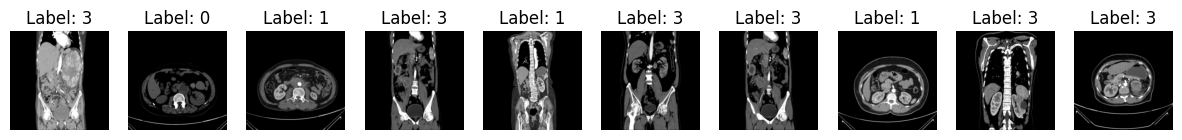

In [20]:
try:
    config = ConfigurationManager()
    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.data_preview(training.train_loader.dataset, 10)
    # training.compile()

    # print(training.train_generator)
    # training.process()
except Exception as e:
    raise e


In [11]:
print(training.train_generator.num_classes)
print(training.train_generator.n)

4
9959


In [31]:
%pwd

'c:\\Users\\supre\\PycharmProjects\\RenalHealth-AI'

In [2]:
a = []
print(*a,4,5)


4 5
